In [0]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt


In [0]:
env_name = "CartPole-v0"
num_envs = 2

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)
env = gym.make(env_name)


In [0]:


class A2C(nn.Module):
  def __init__(self, input_shape, action_space):
    super(A2C, self).__init__()
     
    
    self.actor = nn.Sequential(
            nn.Linear(input_shape[0], 256),
            nn.ReLU(),
            nn.Linear(256, action_space),
            nn.Softmax(dim=1)
     )
    self.critic = nn.Sequential(
            nn.Linear(input_shape[0], 256),
            nn.ReLU(),
            nn.Linear(256,1)
     )
    
  def forward(self,x):
    value = self.critic(x)
    probs = self.actor(x)
    dist  = Categorical(probs)
    return dist, value
    

In [0]:
  
def test_current_model():
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().numpy()[0]) #[0]
        state = next_state
        total_reward += reward
    return total_reward

In [0]:
GAMMA = 0.99
def compute_returns(terminal_reward, rewards,masks, gamma=GAMMA):
    R = terminal_reward
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns
  

In [0]:
def run_optimization(next_state, model, log_probs, values, rewards, masks, entropy):
    next_state = torch.FloatTensor(next_state)
    _, next_value = model(next_state)
   
    discounted_rewards = torch.cat(compute_returns(next_value, rewards, masks)).detach()


    log_probs           = torch.cat(log_probs)
    values              = torch.cat(values)

    # A(s,a) = Q(s,a)- V(s)
    advantage = discounted_rewards - values # important! since we dont want to propagate the policy gradient into our value approximation head
    # policy_loss
    actor_loss  = -(log_probs * advantage).mean() 

    
    value_loss = F.mse_loss(values, discounted_rewards) 
    #value_loss = advantage.pow(2).mean()   # same as above

    actor_loss_list.append(actor_loss)
    value_loss_list.append(value_loss)
    entropy_list.append(entropy)
    
    loss =  actor_loss + 0.5* value_loss - ENTROPY_BETA * entropy
    
    optimizer.zero_grad()
    loss.backward()
    #clip_grad_norm_(model.parameters(),CLIP_GRAD)
    optimizer.step()

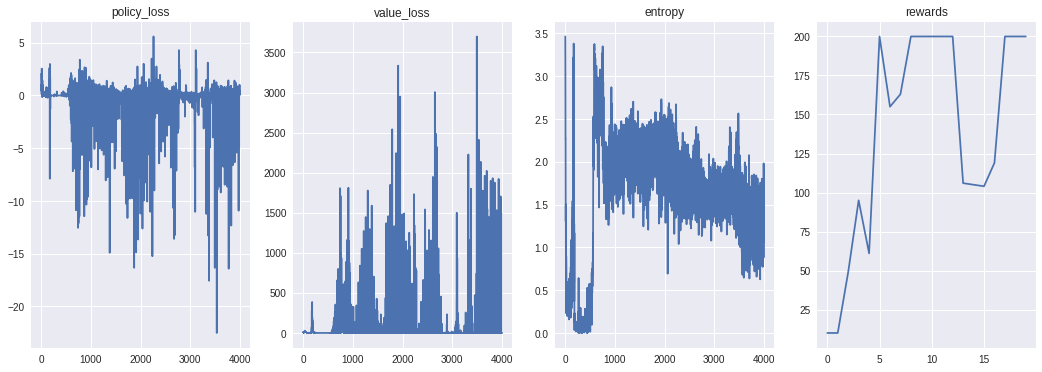

In [13]:
ENTROPY_BETA = 0.001  
GAMMA = 0.99
CLIP_GRAD = 0.1

input_shape  = envs.observation_space.shape
output_shape = envs.action_space.n
model = A2C(input_shape, output_shape)
optimizer = optim.Adam(params = model.parameters(),lr = 0.003)

max_frames   = 20000
frame_idx    = 0
test_rewards = []

actor_loss_list = []
value_loss_list = []
entropy_list = []

plot_rewards = []
n_steps = 5

state = envs.reset()

while frame_idx < max_frames:

    log_probs = []
    values    = []
    rewards   = []
    masks     = []
    entropy = 0


    for _ in range(n_steps):
        state = torch.FloatTensor(state)
        dist, value = model(state)

        action = dist.sample()
        next_state, reward, done, _ = envs.step(action.numpy())

        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1))

        
        state = next_state
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            test_rewards = test_current_model()
            plot_rewards.append(test_rewards)
            
    run_optimization(next_state, model, log_probs, values, rewards,masks, entropy)

    
    
    

# PLOTTING RESULTS

plt.figure(figsize = (18,6))
plt.subplot(1,4,1)
plt.title("policy_loss")
plt.plot(actor_loss_list)
plt.subplot(1,4,2)
plt.title("value_loss")
plt.plot(value_loss_list)
plt.subplot(1,4,3)
plt.title("entropy")
plt.plot(entropy_list)
plt.subplot(1,4,4)
plt.title("rewards")
plt.plot(plot_rewards)

In [0]:
a = torch.Tensor([0.4764, 0.1444, 0.3931, 0.2760])

tensor(0.2760)

**FOR MULTI-ENVIRONMENT**


In [0]:
from multiprocessing import Process, Pipe

def worker(remote, parent_remote, env_fn_wrapper):
    parent_remote.close()
    env = env_fn_wrapper.x()
    while True:
        cmd, data = remote.recv()
        if cmd == 'step':
            ob, reward, done, info = env.step(data)
            if done:
                ob = env.reset()
            remote.send((ob, reward, done, info))
        elif cmd == 'reset':
            ob = env.reset()
            remote.send(ob)
        elif cmd == 'reset_task':
            ob = env.reset_task()
            remote.send(ob)
        elif cmd == 'close':
            remote.close()
            break
        elif cmd == 'get_spaces':
            remote.send((env.observation_space, env.action_space))
        else:
            raise NotImplementedError

class CloudpickleWrapper(object):
    """
    Uses cloudpickle to serialize contents (otherwise multiprocessing tries to use pickle)
    """
    def __init__(self, x):
        self.x = x
    def __getstate__(self):
        import cloudpickle
        return cloudpickle.dumps(self.x)
    def __setstate__(self, ob):
        import pickle
        self.x = pickle.loads(ob)
        

class VecEnv(object):
    """
    An abstract asynchronous, vectorized environment.
    """
    def __init__(self, num_envs, observation_space, action_space):
        self.num_envs = num_envs
        self.observation_space = observation_space
        self.action_space = action_space

    def reset(self):
        """
        Reset all the environments and return an array of
        observations, or a tuple of observation arrays.
        If step_async is still doing work, that work will
        be cancelled and step_wait() should not be called
        until step_async() is invoked again.
        """
        pass

    def step_async(self, actions):
        """
        Tell all the environments to start taking a step
        with the given actions.
        Call step_wait() to get the results of the step.
        You should not call this if a step_async run is
        already pending.
        """
        pass

    def step_wait(self):
        """
        Wait for the step taken with step_async().
        Returns (obs, rews, dones, infos):
         - obs: an array of observations, or a tuple of
                arrays of observations.
         - rews: an array of rewards
         - dones: an array of "episode done" booleans
         - infos: a sequence of info objects
        """
        pass

    def close(self):
        """
        Clean up the environments' resources.
        """
        pass

    def step(self, actions):
        self.step_async(actions)
        return self.step_wait()

class SubprocVecEnv(VecEnv):
    def __init__(self, env_fns, spaces=None):
        """
        envs: list of gym environments to run in subprocesses
        """
        self.waiting = False
        self.closed = False
        nenvs = len(env_fns)
        self.nenvs = nenvs
        self.remotes, self.work_remotes = zip(*[Pipe() for _ in range(nenvs)])
        self.ps = [Process(target=worker, args=(work_remote, remote, CloudpickleWrapper(env_fn)))
            for (work_remote, remote, env_fn) in zip(self.work_remotes, self.remotes, env_fns)]
        for p in self.ps:
            p.daemon = True # if the main process crashes, we should not cause things to hang
            p.start()
        for remote in self.work_remotes:
            remote.close()

        self.remotes[0].send(('get_spaces', None))
        observation_space, action_space = self.remotes[0].recv()
        VecEnv.__init__(self, len(env_fns), observation_space, action_space)

    def step_async(self, actions):
        for remote, action in zip(self.remotes, actions):
            remote.send(('step', action))
        self.waiting = True

    def step_wait(self):
        results = [remote.recv() for remote in self.remotes]
        self.waiting = False
        obs, rews, dones, infos = zip(*results)
        return np.stack(obs), np.stack(rews), np.stack(dones), infos

    def reset(self):
        for remote in self.remotes:
            remote.send(('reset', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def reset_task(self):
        for remote in self.remotes:
            remote.send(('reset_task', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def close(self):
        if self.closed:
            return
        if self.waiting:
            for remote in self.remotes:            
                remote.recv()
        for remote in self.remotes:
            remote.send(('close', None))
        for p in self.ps:
            p.join()
            self.closed = True
            
    def __len__(self):
        return self.nenvs
